### Loading dataset, Scaling data points and splitting data
###### Replicating the study (DOI: 10.1109/ACCESS.2023.3280122), where only 6 features were used

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("CICIDS2017_Wednesday_Paper.csv")
df.columns=df.columns.str.strip()

#using the selected features
selectedFeatures=['Destination Port', 'Total Length of Bwd Packets','Bwd Packet Length Std', 'Flow IAT Mean', 'Bwd Packets/s','Packet Length Mean', 'Label']
df=df[selectedFeatures]

#Remove Heartbleed records as the study did.
df.drop(df[df["Label"]=="Heartbleed"].index,inplace=True)
df["Label"].replace(["BENIGN","DoS Hulk","DoS GoldenEye","DoS slowloris","DoS Slowhttptest"],[0,1,2,3,4],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

C:\Users\dyari\AppData\Local\Temp\ipykernel_21452\2680283562.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Label"].replace(["BENIGN","DoS Hulk","DoS GoldenEye","DoS slowloris","DoS Slowhttptest"],[0,1,2,3,4],inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_21452\2680283562.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_o

### Training the MLP model

In [5]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=50,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01,random_state=42)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.11133773
Iteration 2, loss = 0.07710958
Iteration 3, loss = 0.06882514
Iteration 4, loss = 0.06134590
Iteration 5, loss = 0.05990237
Iteration 6, loss = 0.05395507
Iteration 7, loss = 0.04451349
Iteration 8, loss = 0.04422900
Iteration 9, loss = 0.04370364
Iteration 10, loss = 0.04345668
Iteration 11, loss = 0.04059962
Iteration 12, loss = 0.04440326
Iteration 13, loss = 0.04179418
Iteration 14, loss = 0.04007686
Iteration 15, loss = 0.03883188
Iteration 16, loss = 0.04022545
Iteration 17, loss = 0.03906710
Iteration 18, loss = 0.03813482
Iteration 19, loss = 0.03837074
Iteration 20, loss = 0.03777548
Iteration 21, loss = 0.04172016
Iteration 22, loss = 0.04177869
Iteration 23, loss = 0.03796566
Iteration 24, loss = 0.03773934
Iteration 25, loss = 0.04030849
Iteration 26, loss = 0.03923924
Iteration 27, loss = 0.03792795
Iteration 28, loss = 0.03566539
Iteration 29, loss = 0.03533211
Iteration 30, loss = 0.03583563
Iteration 31, loss = 0.03589873
Iteration 32, los

### Predictions BEFORE sample modification

Accuracy: 0.9908545608095916
---------------------------------------------------------


array([[87299,   595,    63,    40,    74],
       [   49, 46117,    37,     6,     9],
       [   54,   151,  1810,     0,    31],
       [   83,    24,     0,   996,    11],
       [   35,     0,     0,     5,  1050]], dtype=int64)

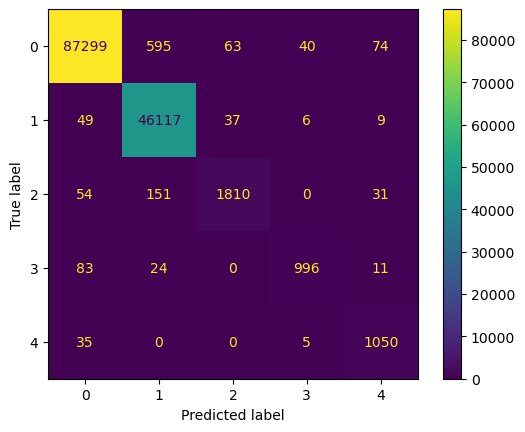

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification 01 - Malicious Shuffle

In [9]:
import random

#Identify the unique 'Flow IAT Mean' values of non-benign classes
non_benign_data = df[df['Label'] != 0]  # Filter out benign (label == 0)
unique_non_benign_values = non_benign_data['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        if y.iloc[idx] != 0:  # If it's non-benign (use iloc for position-based access)
            # Replace 'Flow IAT Mean' with a random value from the unique non-benign values
            X_copy.loc[idx, feature] = random.choice(unique_non_benign_values)

    return X_copy, y_copy


X_evasive1, y_evasive1 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')


### Predictions After sample modification 01 - Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.6449375266170537
---------------------------------------------------------


array([[87299,   595,    63,    40,    74],
       [  247,    10, 45961,     0,     0],
       [    6,     0,  2040,     0,     0],
       [    0,     0,  1114,     0,     0],
       [    1,     0,  1089,     0,     0]], dtype=int64)

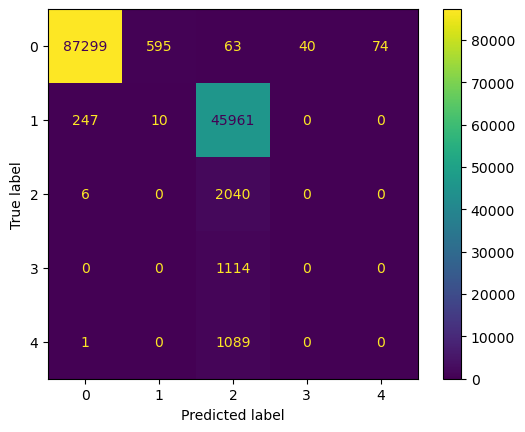

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred1_evasive = clf.predict(X_evasive1)
print("Accuracy:", accuracy_score(y_evasive1,y_pred1_evasive))
print("---------------------------------------------------------")

Perturb01 = ConfusionMatrixDisplay.from_predictions(y_evasive1,y_pred1_evasive)
Perturb01.confusion_matrix

### Sample modification 02 - Benign Shuffle

In [13]:
import random

#Identify the unique 'Flow IAT Mean' values of benign class
benign_data = df[df['Label'] == 0]  # Filter in benign only (label == 0)
unique_benign_values = benign_data['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        if y.iloc[idx] == 0:  # If it's benign (use iloc for position-based access)
            # Replace 'Flow IAT Mean' with a random value from the unique benign values
            X_copy.loc[idx, feature] = random.choice(unique_benign_values)

    return X_copy, y_copy

X_evasive2, y_evasive2 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification 02 - Benign Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.36168154815611486
---------------------------------------------------------


array([[  134,     5, 87932,     0,     0],
       [   49, 46117,    37,     6,     9],
       [   54,   151,  1810,     0,    31],
       [   83,    24,     0,   996,    11],
       [   35,     0,     0,     5,  1050]], dtype=int64)

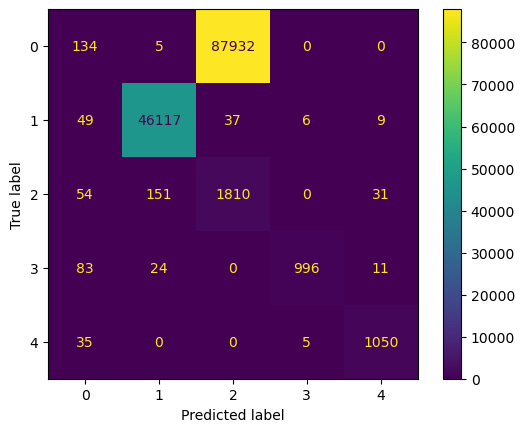

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred2_evasive = clf.predict(X_evasive2)

print("Accuracy:", accuracy_score(y_evasive2,y_pred2_evasive))
print("---------------------------------------------------------")


Perturb02=ConfusionMatrixDisplay.from_predictions(y_evasive2, y_pred2_evasive)
Perturb02.confusion_matrix

### Sample modification 03 - Both Benign and Malicious Shuffle

In [17]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification 03 - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.015230368343932033


array([[   63,     2, 88006,     0,     0],
       [  228,     9, 45981,     0,     0],
       [    7,     1,  2038,     0,     0],
       [    0,     0,  1114,     0,     0],
       [    2,     0,  1088,     0,     0]], dtype=int64)

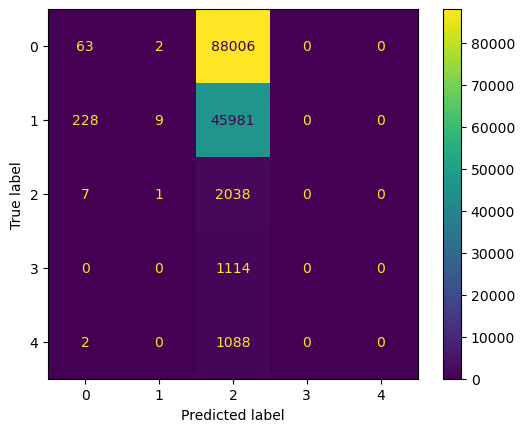

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)
print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))

Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix

### Combining clean and shuffled samples and splitting them again into 80:20 ratio

In [21]:
from sklearn.model_selection import train_test_split

X_combined = np.concatenate((X,X_evasive3))
y_combined = np.concatenate((y,y_evasive3))

# Split the combined datasets into training and test sets
mixed_X_train, mixed_X_test, mixed_y_train, mixed_y_test = train_test_split(X_combined, y_combined, test_size=0.2,random_state=42)

### Adversarial Learning
#### Retraing the same MLP model with perturbed samples included

In [23]:
import numpy as np
from sklearn.neural_network import MLPClassifier
import time

# Define and configure the MLPClassifier
mixed_clf = MLPClassifier(hidden_layer_sizes=(100, 200, 250), max_iter=100, solver="adam",
                    verbose=True, activation='relu', learning_rate_init=0.01,random_state=42)

# Measure the training time
start_time = time.time()

# Fit data onto the model
mixed_clf.fit(mixed_X_train, mixed_y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time} seconds")


Iteration 1, loss = 0.29581003
Iteration 2, loss = 0.21615832
Iteration 3, loss = 0.19930655
Iteration 4, loss = 0.19978892
Iteration 5, loss = 0.18930551
Iteration 6, loss = 0.18023437
Iteration 7, loss = 0.19121375
Iteration 8, loss = 0.19001400
Iteration 9, loss = 0.17321337
Iteration 10, loss = 0.17272333
Iteration 11, loss = 0.18242179
Iteration 12, loss = 0.18649632
Iteration 13, loss = 0.16922482
Iteration 14, loss = 0.16799148
Iteration 15, loss = 0.16786194
Iteration 16, loss = 0.17161843
Iteration 17, loss = 0.16811959
Iteration 18, loss = 0.16832046
Iteration 19, loss = 0.17469000
Iteration 20, loss = 0.16979688
Iteration 21, loss = 0.17065260
Iteration 22, loss = 0.16736494
Iteration 23, loss = 0.18235289
Iteration 24, loss = 0.17000046
Iteration 25, loss = 0.16666664
Iteration 26, loss = 0.16582376
Iteration 27, loss = 0.16642739
Iteration 28, loss = 0.16587815
Iteration 29, loss = 0.17280104
Iteration 30, loss = 0.16929150
Iteration 31, loss = 0.17339030
Iteration 32, los

### Predictions After adversarial learning

Accuracy: 0.9340619680355134


array([[105297,    284,     38,     31,     55],
       [  9291,  46055,     52,     31,      6],
       [   461,     88,   1840,      0,     26],
       [   319,      0,      0,   1009,      7],
       [   268,      0,      1,      4,   1084]], dtype=int64)

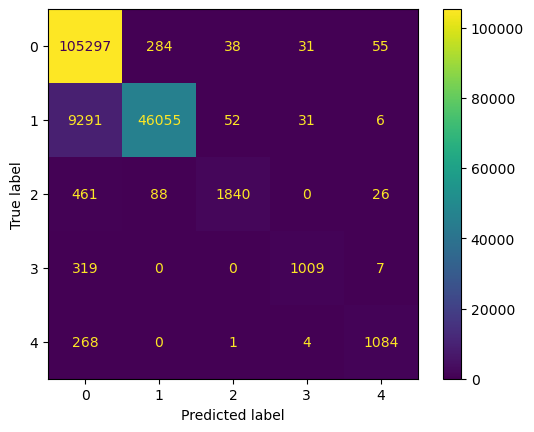

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
mixed_y_pred = mixed_clf.predict(mixed_X_test)
print("Accuracy:", accuracy_score(mixed_y_test,mixed_y_pred))

mixed=ConfusionMatrixDisplay.from_predictions(mixed_y_test, mixed_y_pred)
mixed.confusion_matrix

### Perturbations after re-training - Both Benign and Malicious Shuffle

In [27]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    
    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy

#X_REafter, y_REafter = SystematicShuffling(X_combined, y_combined, feature='Flow IAT Mean')
X_REafter, y_REafter = SystematicShuffling(mixed_X_test, mixed_y_test, feature='Flow IAT Mean')

### Predictions After sample modification 03 - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.6357949316378642


array([[105699,      0,      6,      0,      0],
       [ 55434,      0,      1,      0,      0],
       [  2415,      0,      0,      0,      0],
       [  1335,      0,      0,      0,      0],
       [  1357,      0,      0,      0,      0]], dtype=int64)

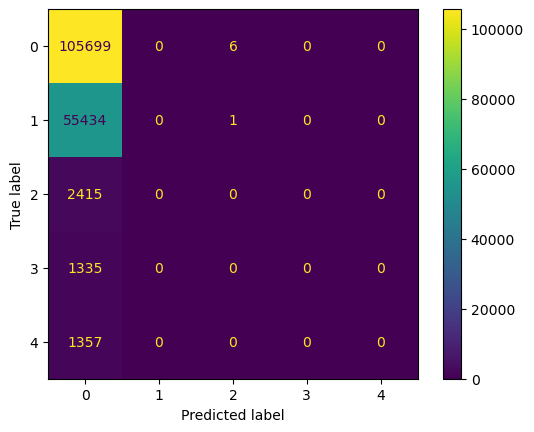

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
REafter_y_pred = mixed_clf.predict(X_REafter)
print("Accuracy:", accuracy_score(y_REafter,REafter_y_pred))

Pert_ReTrain=ConfusionMatrixDisplay.from_predictions(y_REafter, REafter_y_pred)
Pert_ReTrain.confusion_matrix